<a href="https://colab.research.google.com/github/rubensly/thermometry-optimization/blob/main/(Shared)_Thermometry_Optimization_NN_Spring21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Network-based Thermometry Optimization

### Nanoscale Thermal Transport Lab, University of Rochester

This computational project is an effort to improve on the findings of the paper *Apparent self-heating of individual upconverting nanoparticle thermometers*, by Dr. Andrea Pickel (UR) and other researchers. The goal is to use neural networks to optimize the sensitivity of luminescence thermometry techniques.

**Resources**
- [Fluorescence spectra shape based dynamic thermometry](https://aip.scitation.org/doi/10.1063/1.4862921)
- [TensorFlow Documentation (Regression)](https://www.tensorflow.org/tutorials/keras/regression)

**Contact**
- Kelly Jean, kjean@u.rochester.edu (*Feel free to reach out*)

### 1. Environment Setup

The machine learning libraries **TensorFlow** and **Keras** will be used to create our neural network model. A few other libraries (Pandas, Numpy ...) are also necessary for data cleaning and pre-processing.


> **!** To connect Google Drive with Colab, copy and paste the authorization code





In [ ]:
# Install packages
! pip install pandas tensorflow==2.3.0 keras scipy

In [ ]:
# Import packages and libraries
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import glob, re
import math

from scipy.signal import savgol_filter
from scipy import stats
from scipy.integrate import simps
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


### 2. Parameters Definition

The variable ```PATH``` is a list of folders containing the CSV datasets of interest. If using Colab, each path must start with ```/content/drive/My Drive/```. Also, notice that the paths end with ```/*.csv```.

The other parameters are more technical and can be altered to change wavelength range and the filtering function.

> **!** Update ```PATH``` to reflect the location of your datasets


In [ ]:
# Path to datasets
PATH = [
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/July 27 (Mesolight Thermometry)/*.csv",
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/Jan 30 High Temp Power Sweep/*.csv",
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/Glass/*.csv",
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/July 29 (Mesolight Power Sweep)/*.csv",
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/May 18 Single Temp Cal/*.csv",
        "/content/drive/My Drive/College/Senior/FALL 20/Research/Neural Network Thermometry/May 21 Single Temp Cal/*.csv",
]

In [ ]:
# Constant parameters
WL_RANGE = [515,575]      # Wavelength range to be considered by NN model
NOISE_WIN_LENGTH = 11     # Savitzky–Golay filter
NOISE_DEGREE = 3          # Savitzky–Golay filter
ARTIF_WIN_LENGTH = 300

### 2. Data Pre-processing

The pre-processing stage consists of these broad steps.

*   Loading data
*   Normalizing spectra
*   Reducing noise
*   Combining spectra into one dataset ```dframe```
*   Splitting  ```dframe``` into input/output and training/testing sets



In [ ]:
# Noise removal function using Savitzky–Golay filter
def remove_noise(df, window_length=11, degree=3, plot=False):

  y = df["Intensity"].values
  w = savgol_filter(y, window_length, degree)
  df["Intensity"] = w
  if plot:
    df.plot(x="Wavelength",y="Intensity")
  
  return df

In [ ]:
# Get dataset size for given wavelength range

SIZE = 4000
for path in PATH:
  for frame in glob.glob(path):
    df = pd.read_csv(frame,header=None)
    df.columns = ["id","wl","i"]

    lower_bound = df[ df['wl'] < WL_RANGE[0]].index 
    upper_bound = df[ df['wl'] >= WL_RANGE[1] ].index
    df.drop(lower_bound, inplace = True) 
    df.drop(upper_bound, inplace = True) 

    if len(df.index) < SIZE:
      SIZE = len(df.index)    
      
print(SIZE)

592


In [ ]:
# Pre-allocate dframe
size = math.floor(SIZE/ 6)
df_columns = list(range(size))
df_columns.append("Temperature")
dframe = pd.DataFrame(columns=df_columns)

for path in PATH:
  for frame in glob.glob(path):

    # load data
    df = pd.read_csv(frame,header=None)
    df.columns = ["idx", "Wavelength", "Intensity"]
    
    # normalize
    df["Intensity"] = df["Intensity"].transform(lambda x: x/x.max())
    print(df.shape)

    # getting temperature
    temp = re.findall(r'[/][\d]{3}[K]',frame) 
    temp = int(temp[0][1:4])

    # denoising
    df = remove_noise(df,NOISE_WIN_LENGTH,NOISE_DEGREE,False)

    # drop data outside range
    lower_bound = df[ df['Wavelength'] < WL_RANGE[0]].index 
    upper_bound = df[ df['Wavelength'] >= WL_RANGE[1] ].index
    df.drop(lower_bound, inplace = True) 
    df.drop(upper_bound, inplace = True) 
    df = df.iloc[:SIZE]

    # select every n-th row
    df = df[df.index % 6 == 0]
    df = df.reset_index()
    df = df.iloc[:size]

    df_T = df.T
    df_T = df_T.reset_index(drop=True)
    
    df1 = df_T.drop([0, 1, 2])
    df1["Temperature"] = temp

    dframe = dframe.append(df1, ignore_index=True)

dframe.tail(24)


In [ ]:
# split the data into train and test
dframe = dframe.dropna()
train_dataset = dframe.sample(frac=0.8, random_state=0).copy()
test_dataset = dframe.drop(train_dataset.index).copy()

# stats on the data
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

train_dataset

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,Temperature
26,0.005552,0.007460,0.008982,0.011370,0.011185,0.013776,0.019049,0.064483,0.101407,0.074316,0.092676,0.127861,0.169674,0.247344,0.231501,0.203332,0.160623,0.141003,0.149401,0.138507,0.148602,0.138232,0.158017,0.175488,0.171260,0.179995,0.193251,0.188294,0.158298,0.127029,0.098985,0.081052,0.064736,0.053275,0.041370,0.039658,0.036849,0.040510,0.046013,0.051540,...,0.281206,0.321034,0.421579,0.598961,0.541504,0.635975,0.561643,0.535530,0.503632,0.488844,0.527492,0.736113,0.699039,0.987464,0.917303,0.572995,0.487440,0.392440,0.272055,0.162517,0.123840,0.103862,0.083687,0.057990,0.053181,0.043213,0.038262,0.032909,0.031116,0.027375,0.024746,0.022143,0.020700,0.016203,0.013818,0.010870,0.010761,0.009468,0.007733,350
61,0.007911,0.004110,0.009506,0.044374,0.058187,0.034462,0.056990,0.064956,0.085756,0.161576,0.122973,0.089418,0.087751,0.074783,0.090658,0.080394,0.081612,0.069730,0.072091,0.072473,0.084210,0.099360,0.104216,0.102343,0.107411,0.077538,0.061934,0.047842,0.044553,0.030788,0.025492,0.027481,0.027223,0.033368,0.036375,0.046174,0.059888,0.072949,0.135989,0.527922,...,0.465100,0.440502,0.376795,0.335907,0.300584,0.282509,0.292266,0.428371,0.393188,0.546922,0.537055,0.321624,0.262864,0.210969,0.156268,0.102255,0.069769,0.058990,0.048375,0.034501,0.025065,0.030709,0.022701,0.019430,0.019403,0.013137,0.014035,0.017620,0.013947,0.008621,0.009106,0.008718,0.003522,0.006860,0.006729,0.002340,0.003534,0.003413,0.002592,300
2,0.005538,0.006488,0.009169,0.039738,0.062112,0.036714,0.050916,0.077437,0.092118,0.139428,0.133038,0.118255,0.096225,0.078461,0.087013,0.074838,0.084045,0.081647,0.088757,0.104659,0.095759,0.100674,0.110917,0.111018,0.095612,0.077573,0.059627,0.050615,0.041370,0.031302,0.026938,0.025455,0.027231,0.028015,0.034878,0.045986,0.055784,0.072458,0.127024,0.462453,...,0.512756,0.578353,0.494326,0.470942,0.458726,0.420027,0.450529,0.665281,0.632781,0.954745,0.892937,0.549401,0.458176,0.376566,0.260640,0.152275,0.105741,0.095202,0.077044,0.053154,0.045380,0.038923,0.033346,0.032088,0.026856,0.022970,0.020282,0.020265,0.016180,0.013883,0.012444,0.009454,0.008804,0.006941,0.006654,0.004439,0.004373,0.003413,0.003034,296
62,0.005856,0.005955,0.007410,0.025576,0.042455,0.028684,0.040484,0.067336,0.086732,0.112106,0.123116,0.107990,0.082811,0.076792,0.079471,0.076258,0.082910,0.071856,0.086502,0.100912,0.091372,0.094584,0.119058,0.115569,0.084801,0.062764,0.048513,0.038728,0.032229,0.024370,0.020425,0.019164,0.017511,0.022204,0.028001,0.032655,0.038541,0.051809,0.083839,0.294230,...,0.445949,0.524493,0.477647,0.469443,0.441715,0.448622,0.486521,0.712315,0.580260,0.895643,0.946686,0.513087,0.424104,0.333563,0.259536,0.154332,0.100306,0.095711,0.071816,0.051767,0.039602,0.034801,0.033642,0.029831,0.024404,0.023740,0.021038,0.017367,0.014911,0.013222,0.012910,0.010286,0.008268,0.007790,0.005786,0.004532,0.004666,0.003147,0.003065,300
85,0.028158,0.087801,0.071444,0.088173,0.106886,0.174736,0.213457,0.290129,0.183599,0.182539,0.244626,0.260579,0.226868,0.200555,0.179131,0.180968,0.177731,0.240142,0.279138,0.268640,0.250178,0.257106,0.132276,0.105988,0.082459,0.053759,0.049364,0.049777,0.076891,0.036794,0.039910,0.015467,0.063042,0.084523,0.106757,0.275212,0.850387,0.731773,0.630763,0.846696,...,0.488207,0.455096,0.416683,0.554447,0.492505,0.638711,0.791416,0.495961,0.327643,0.217665,0.205314,0.111613,0.081577,0.054730,0.074916,0.028231,0.022889,0.033217,-0.002493,0.031711,-0.021886,-0.011776,-0.002428,0.010740,-0.016552,0.002752,-0.037385,-0.004565,-0.000283,-0.000049,-0.017224,-0.032383,0.001570,-0.028603,-0.027138,-0.007098,-0.044961,-0.000542,-0.023958,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [ ]:
# convert temperature values to numbers
train_dataset_copy = train_dataset.copy()
test_dataset_copy = test_dataset.copy()

train_temp = train_dataset_copy.pop("Temperature").astype('float32')
test_temp = test_dataset_copy.pop("Temperature").astype('float32')

In [ ]:
train_features = train_dataset.drop(["Temperature"], axis=1)
test_features = test_dataset.drop(["Temperature"], axis=1)

print(train_features)

          0         1         2   ...        95        96        97
26  0.005552  0.007460  0.008982  ...  0.010761  0.009468  0.007733
61  0.007911  0.004110  0.009506  ...  0.003534  0.003413  0.002592
2   0.005538  0.006488  0.009169  ...  0.004373  0.003413  0.003034
62  0.005856  0.005955  0.007410  ...  0.004666  0.003147  0.003065
85  0.028158  0.087801  0.071444  ... -0.044961 -0.000542 -0.023958
..       ...       ...       ...  ...       ...       ...       ...
69  0.005900  0.007530  0.008269  ...  0.003934  0.003661  0.002905
20  0.006604  0.006717  0.010604  ...  0.009656  0.008340  0.007304
98  0.019227  0.087191  0.110399  ...  0.019686  0.044927 -0.001268
72  0.007061  0.007486  0.007921  ...  0.004316  0.003323  0.002435
77  0.008463  0.010164  0.010443  ...  0.003815  0.004264  0.002353

[83 rows x 98 columns]


### 3. Model Setup

Our model is using Keras' Sequential model with 3 layers and RMSprop as optimizer.

In [ ]:
# create NN model 

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Layer, InputSpec

def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation='relu', input_shape=[size]),
                            layers.Dense(64, activation='relu'),
                            layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
_________________________________________________________________


### 5. Model Training

The model is trained with the training set with 3000 epochs (or passes of the entire training dataset). The model is also set to be saved as a "SavedModel" for future use, if need be.

In [ ]:
# train NN
history = model.fit(
    train_features, train_temp,
    epochs=3000, validation_split = 0.2)

# Save entire model as a "SavedModel"
!mkdir -p saved_model
model.save('saved_model/model_003')


Streaming output truncated to the last 5000 lines.
3/3 [==============================] - 0s 16ms/step - loss: 35.4508 - mae: 5.0397 - mse: 35.4508 - val_loss: 118.4038 - val_mae: 9.0660 - val_mse: 118.4038
Epoch 502/3000
3/3 [==============================] - 0s 12ms/step - loss: 27.3531 - mae: 4.3426 - mse: 27.3531 - val_loss: 50.1885 - val_mae: 4.7879 - val_mse: 50.1885
Epoch 503/3000
3/3 [==============================] - 0s 11ms/step - loss: 25.6890 - mae: 4.0507 - mse: 25.6890 - val_loss: 94.6856 - val_mae: 7.1856 - val_mse: 94.6856
Epoch 504/3000
3/3 [==============================] - 0s 10ms/step - loss: 15.9121 - mae: 3.1986 - mse: 15.9121 - val_loss: 217.6892 - val_mae: 13.2541 - val_mse: 217.6892
Epoch 505/3000
3/3 [==============================] - 0s 10ms/step - loss: 41.5065 - mae: 5.1937 - mse: 41.5065 - val_loss: 53.7724 - val_mae: 5.2310 - val_mse: 53.7724
Epoch 506/3000
3/3 [==============================] - 0s 11ms/step - loss: 23.9327 - mae: 4.0715 - mse: 23.9327 - 

### 6. Results

The performance of the model can be examined by plotting predicted values against true temperatures of the training and testing sets. The loss history gives a hint on how to adjust the number of epochs.

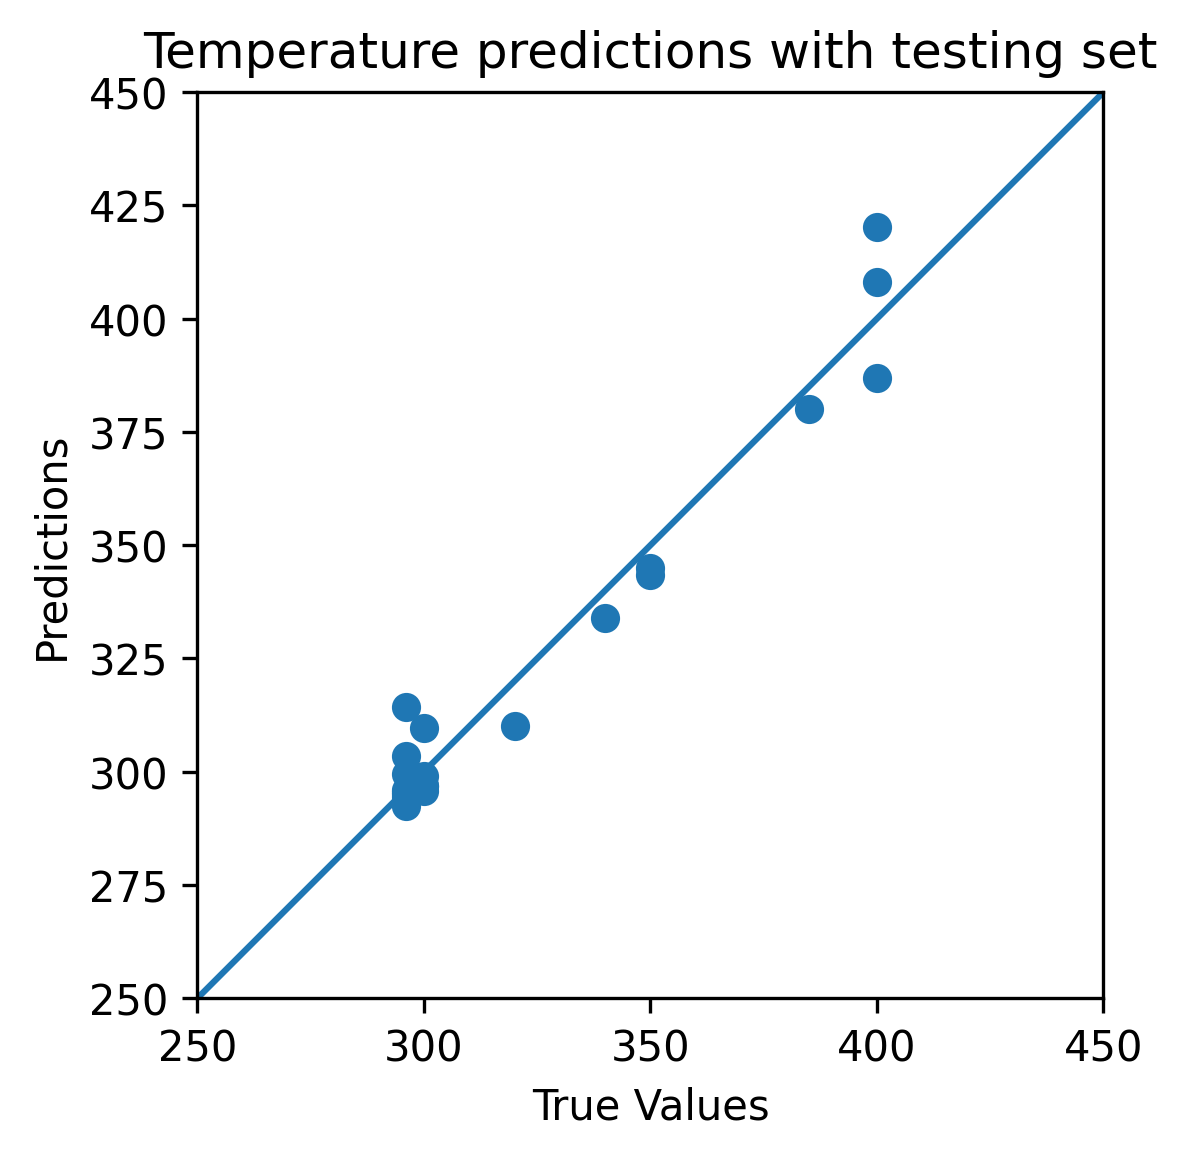

In [ ]:
# predict temperature of testing data sets
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')

plt.scatter(test_temp, test_predictions)
plt.title('Temperature predictions with testing set')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[250,450]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


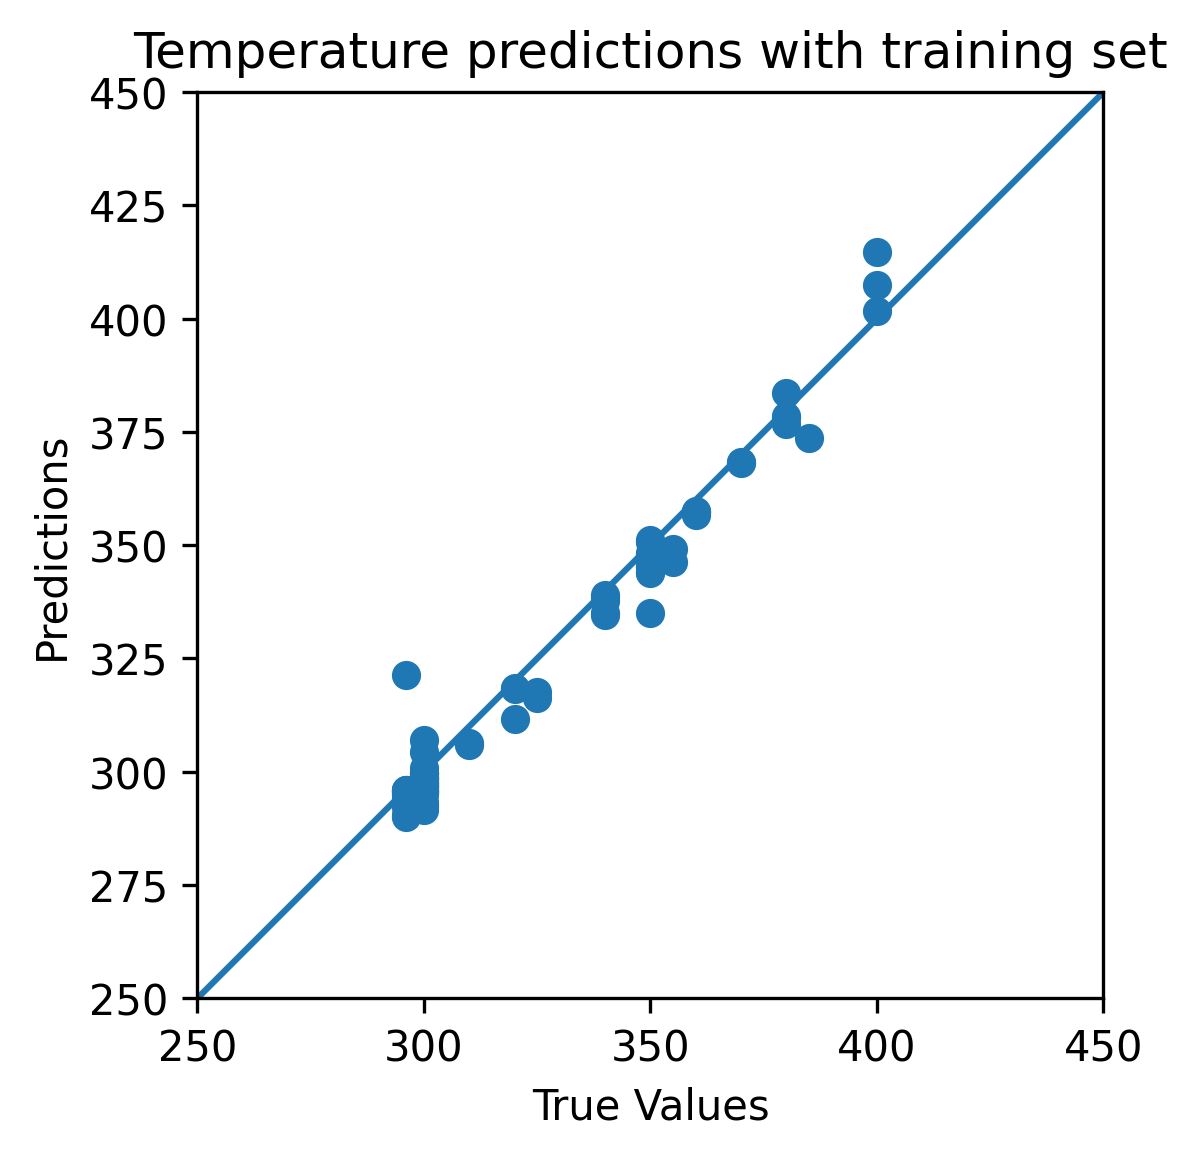

In [ ]:
# predict temperature of traning data sets
test_predictions = model.predict(train_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(train_temp, test_predictions)
plt.title('Temperature predictions with training set')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[250,450]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

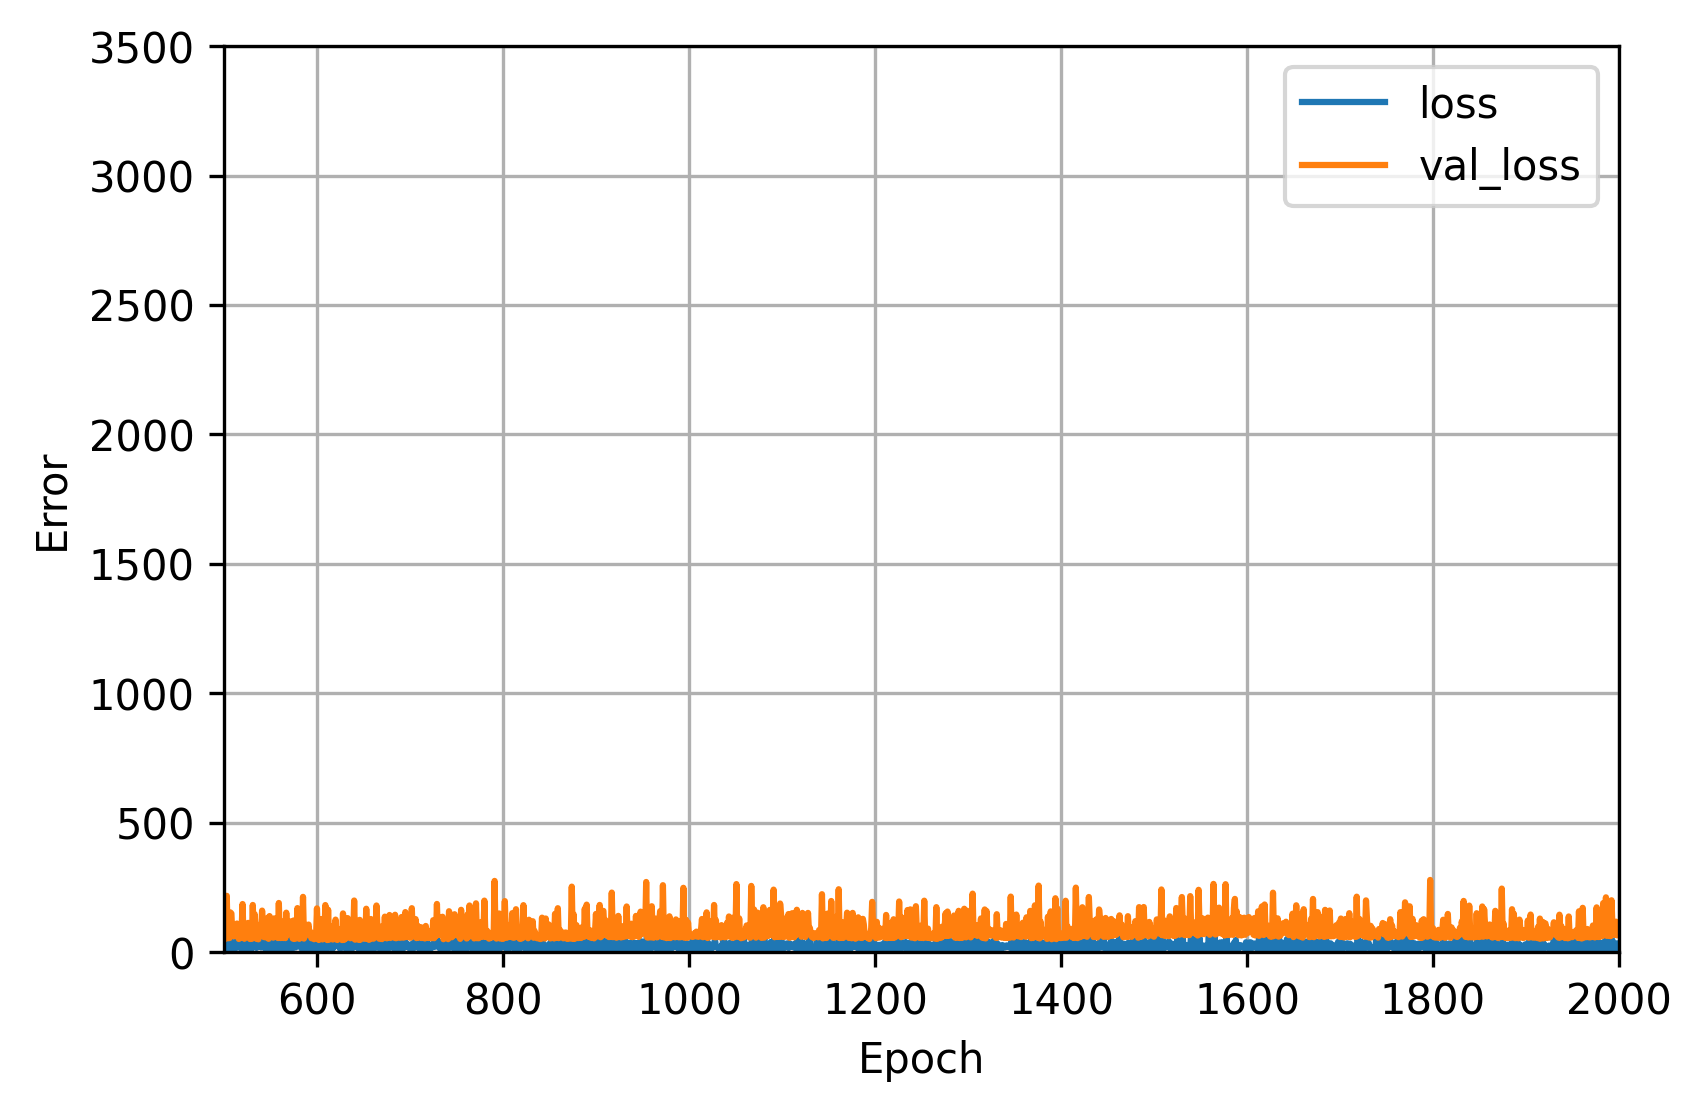

In [ ]:
# Loss plot
def plot_loss(history):
  plt.figure(dpi=300)
  plt.plot(history.history['loss'],label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,3500])
  plt.xlim([500, 2000])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history)

### 7. Run saved models

Previous models saved as a **SavedModel** can be loaded and used to predict temperature values of new spectra.

In [ ]:
ls saved_model/model_003/

assets/  saved_model.pb  variables/


In [ ]:
new_model = keras.models.load_model('saved_model/model_003')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 10,561
Trainable params: 10,561
Non-trainable params: 0
_________________________________________________________________


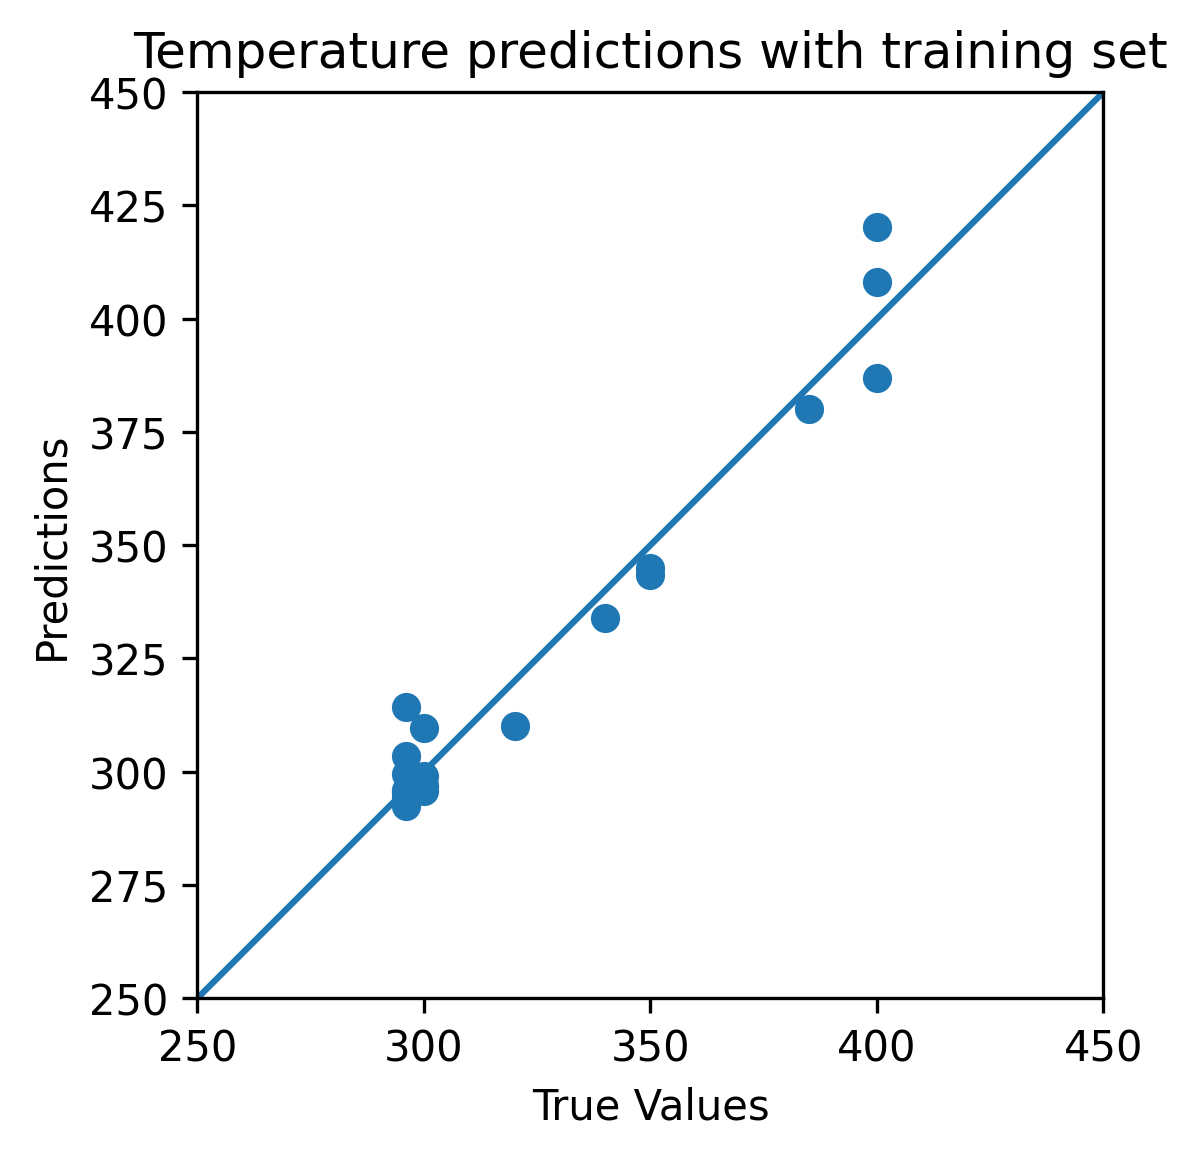

In [ ]:
test_predictions = new_model.predict(test_features).flatten()

plt.figure(dpi=300)
a = plt.axes(aspect='equal')
plt.scatter(test_temp, test_predictions)
plt.title('Temperature predictions with training set')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims=[250,450]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)